<a href="https://colab.research.google.com/github/wajnryt/JerusMLDeepLearning2019/blob/David/Resnet18IntstanceClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode


from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import glob
basedir = '/content/gdrive/My Drive/videos_2/yt_bb_detection_train'
#basedir = '/content/gdrive/My Drive/drive-download-20190703T155220Z-001'

In [0]:
import pandas as pd
import os
from torch.utils.data.dataset import Dataset
import imageio
from PIL import Image
import datetime

class InstanceDataset(Dataset):
    def __init__(self, basedir, transform=None, force=False):
        super().__init__()
        self.transform = transform
        cach_file = os.path.join(basedir, 'data.csv')
        if not force and os.path.exists(cach_file):
          self.data = pd.read_csv(cach_file)
          print('load from csv')
          return
        print('start glob')
        print(datetime.datetime.now())
        files = glob.glob(os.path.join(basedir ,'*','*','*.jpg'))
        print('finish glob')
        print(datetime.datetime.now())
        self.data = pd.DataFrame([self._split_file(f) for f in files], 
                            columns=['class_id',  'file_path'])
        self.data.to_csv(cach_file)
        print('finish sort')
        
    def _split_file(self, f):
        parts = f.split(os.sep)[-3:-1]
        return parts[0], f 

    def __getitem__(self, index):
      dat = self.data.iloc[index]
      img = Image.open(dat['file_path'])
      if self.transform:
        img = self.transform(img)
    # return (img, dat['class_id'], dat['instance_id'])
      return (img, int(dat['class_id']))        
    
    
    def __len__(self):
        return len(self.data)
      

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        #transforms.Pad(256),
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# dataset = InstanceDataset(basedir, data_transforms['train'], True)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=3,
#                                              shuffle=True, num_workers=4)

#device = torch.device("cuda:0")


In [0]:

device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet18(pretrained=True)

optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

batch_size = 3
dataset_train = InstanceDataset(basedir, data_transforms['train'], True)
dataset_val = InstanceDataset(basedir, data_transforms['val'], True)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                                             shuffle=True, num_workers=4)

test_loader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size,
                                             shuffle=True, num_workers=4)



# train_loader = torch.utils.data.DataLoader(
#                  dataset=train_set,
#                  batch_size=batch_size,
#                  shuffle=True)
# test_loader = torch.utils.data.DataLoader(
#                 dataset=test_set,
#                 batch_size=batch_size,
#                 shuffle=False)


print ('==>>> total trainning batch number: {}'.format(len(train_loader)))
print ('==>>> total testing batch number: {}'.format(len(test_loader)))


In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
# train_set = ImageFolder(root='/content/JerusML/My Drive/JerusML/Grayscale/', transform=ToTensor())
# test_set = ImageFolder(root='/content/JerusML/My Drive/JerusML/GrayscaleTEST/', transform=ToTensor())


## training
model = models.resnet18()
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    # trainning
    ave_loss = 0
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        if use_cuda:
            x, target = x.cuda(), target.cuda()
        x, target = Variable(x), Variable(target)
        out = model(x)
        loss = criterion(out, target)
        ave_loss = ave_loss * 0.9 + loss.data * 0.1
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % 100 == 0 or (batch_idx+1) == len(train_loader):
            print ('==>>> epoch: {}, batch index: {}, train loss: {:.6f}'.format(
                epoch, batch_idx+1, ave_loss))
    # testing
    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    for batch_idx, (x, target) in enumerate(test_loader):
        if use_cuda:
            x, target = x.cuda(), target.cuda()
        x, target = Variable(x, volatile=True), Variable(target, volatile=True)
        out = model(x)
        loss = criterion(out, target)
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.data.size()[0]
        correct_cnt += (pred_label == target.data).sum()
        # smooth average
        ave_loss = ave_loss * 0.9 + loss.data * 0.1
        
        if(batch_idx+1) % 100 == 0 or (batch_idx+1) == len(test_loader):
            print ('==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(
                epoch, batch_idx+1, ave_loss,float(correct_cnt)/total_cnt))

torch.save(model.state_dict(), "resnet18s")


start glob
2019-07-04 08:49:06.304776
finish glob
2019-07-04 08:58:56.347895
finish sort
start glob
2019-07-04 08:58:57.800967
finish glob
2019-07-04 08:59:02.344304
finish sort
==>>> total trainning batch number: 33004
==>>> total testing batch number: 33004
==>>> epoch: 0, batch index: 100, train loss: 3.551440


Using 
https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5

In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

In [32]:
epochs = 10
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in train_loader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device),                                     labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals =                        top_class == labels.view(*top_class.shape)
                    accuracy +=                  torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(test_loader):.3f}.. "
                  f"Test accuracy: {accuracy/len(test_loader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'aerialmodel.pth')

Epoch 1/10.. Train loss: -48.425.. Test loss: -56.317.. Test accuracy: 0.967
Epoch 2/10.. Train loss: -55.721.. Test loss: -68.279.. Test accuracy: 0.900
Epoch 3/10.. Train loss: -61.286.. Test loss: -69.569.. Test accuracy: 0.833
Epoch 4/10.. Train loss: -69.840.. Test loss: -77.039.. Test accuracy: 0.833
Epoch 5/10.. Train loss: -73.416.. Test loss: -87.482.. Test accuracy: 0.833
Epoch 6/10.. Train loss: -81.879.. Test loss: -99.011.. Test accuracy: 0.833
Epoch 7/10.. Train loss: -93.072.. Test loss: -105.631.. Test accuracy: 0.833
Epoch 8/10.. Train loss: -97.685.. Test loss: -126.862.. Test accuracy: 0.833
Epoch 9/10.. Train loss: -105.821.. Test loss: -126.379.. Test accuracy: 0.833
Epoch 10/10.. Train loss: -113.414.. Test loss: -132.090.. Test accuracy: 0.833


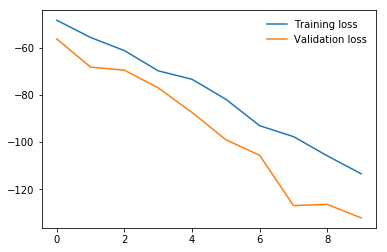

In [33]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [0]:
# print(len(dataset.data['instance_id'].unique()), ' unique instances')
# print(len(dataset.data['class_id'].unique()), ' classes')
# print(len(dataset) , ' images')
# import numpy as np

# plt.figure(figsize=(15,15))
# plt.hist(dataset.data['class_id'].values.astype(int), normed=True)
# plt.title('images per class')
# plt.xlabel('class id')

# plt.figure(figsize=(15,15))
# _, count = np.unique(dataset.data['instance_id'], return_counts=True)
# plt.hist(count, normed=True)
# plt.title('images per instance')
# plt.xlabel('images per instance')

In [0]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# #example. 
# # this is not how you're supposed to use dataset!
# # you should axes it via torch DataLoader...
# # never dirrectly call __getitem__, or access the members (dataset.data)

# print(len(dataset))
# im, class_id, instance_id = dataset.__getitem__(500)


# #just for fun, lets find another one of this guy
# thisguy = dataset.data[dataset.data['instance_id']==instance_id]
# for ind, dat in thisguy.iterrows():
#   plt.figure()
#   plt.imshow(imageio.imread(dat['file_path']))
#   plt.title(f'class id {dat["class_id"]}, instance {dat["instance_id"]}')


In [0]:
# def imshow(inp, title=None):
#     """Imshow for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated


# # Get a batch of training data
# inputs, classes, instance= next(iter(dataloader))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs,3)
# plt.figure(figsize=(15,15))
# imshow(out)#, title=[class_names[x] for x in classes])

In [0]:
# import torch
# import torch.nn as nn
# from torch.autograd import Variable
# import torchvision.datasets as dset
# import torchvision.transforms as transforms
# import torch.nn.functional as F
# import torch.optim as optim
# from torchvision.datasets import ImageFolder
# from torchvision.transforms import ToTensor


# batch_size = 3
# dataset_train = InstanceDataset(basedir,dataset_train, True)
# dataset_val = InstanceDataset(basedir, dataset_train, True)

# train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
#                                              shuffle=True, num_workers=4)

# test_loader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size,
#                                              shuffle=True, num_workers=4)

# print ('==>>> total trainning batch number: {}'.format(len(train_loader)))
# print ('==>>> total testing batch number: {}'.format(len(test_loader)))


# model = models.resnet18()

# epochs = 1
# steps = 0
# running_loss = 0
# print_every = 10
# train_losses, test_losses = [], []
# for epoch in range(epochs):
#     for inputs, labels in trainloader:
#         steps += 1
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         logps = model.forward(inputs)
#         loss = criterion(logps, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
        
#         if steps % print_every == 0:
#             test_loss = 0
#             accuracy = 0
#             model.eval()
#             with torch.no_grad():
#                 for inputs, labels in testloader:
#                     inputs, labels = inputs.to(device), labels.to(device)
#                     logps = model.forward(inputs)
#                     batch_loss = criterion(logps, labels)
#                     test_loss += batch_loss.item()
                    
#                     ps = torch.exp(logps)
#                     top_p, top_class = ps.topk(1, dim=1)
#                     equals =  top_class == labels.view(*top_class.shape)
#                     accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
#             train_losses.append(running_loss/len(trainloader))
#             test_losses.append(test_loss/len(testloader))                    
#             print(f"Epoch {epoch+1}/{epochs}.. "
#                   f"Train loss: {running_loss/print_every:.3f}.. "
#                   f"Test loss: {test_loss/len(testloader):.3f}.. "
#                   f"Test accuracy: {accuracy/len(testloader):.3f}")
#             running_loss = 0
#             model.train()
# torch.save(model, 'resnet18i.pth')

start glob
finish glob
finish sort
start glob
finish glob
finish sort
==>>> total trainning batch number: 33004
==>>> total testing batch number: 33004


RuntimeError: ignored